---
title: "Face Detection and blurring"
description: "In this tutorial we will show how to use the Kornia Face Detection and how we can blurring these detected faces."
author:
    - "Edgar Riba"
date: 11-30-2021
categories:
    - Intermediate
    - Face detection
    - Blur
    - kornia.contrib
image: "../tutorials/assets/face_detection.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/face_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://raw.githubusercontent.com/kornia/data/main/crowd.jpg"
download_image(url)

Import the needed libraries

In [ ]:
import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.contrib import FaceDetector, FaceDetectorResult

# select the device and type
device = torch.device("cpu")  # use 'cuda:0'
dtype = torch.float32

Read the image with kornia

In [ ]:
# load the image (face detector expects a image in rage 0-255 (8 bits))
img = K.io.load_image("crowd.jpg", K.io.ImageLoadType.RGB8, device=device)[None, ...].to(dtype=dtype)  # BxCxHxW
img_vis = K.tensor_to_image(img.byte())  # to later visualize

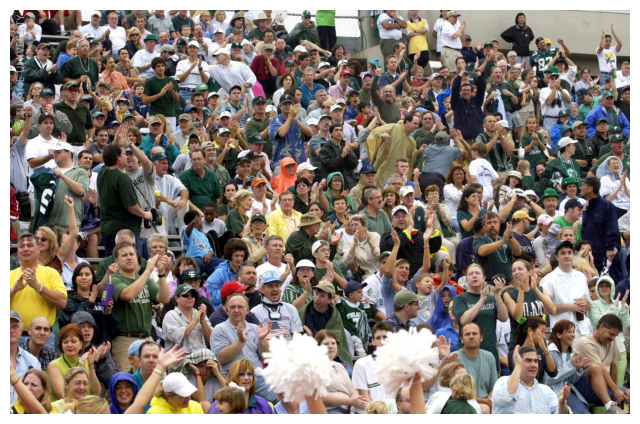

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis("off")
plt.show()

Create the [FaceDetector](https://kornia.readthedocs.io/en/latest/contrib.html#kornia.contrib.FaceDetector) object and apply to the image

In [ ]:
# create the detector and find the faces !
face_detection = FaceDetector().to(device, dtype)

with torch.no_grad():
    dets = face_detection(img)

# to decode later the detections
dets = [FaceDetectorResult(o) for o in dets]

Create a function to crop the faces from the original image and apply blurring using the [gaussian_blurd2d](https://kornia.readthedocs.io/en/latest/filters.html?highlight=gaussian%20blur#kornia.filters.gaussian_blur2d) operator.

Alternatively, explore other blur operator in [`kornia.filters`](https://kornia.readthedocs.io/en/latest/filters.html).

In [ ]:
# blurring paramters
k: int = 21  # kernel_size
s: float = 35.0  # sigma


def apply_blur_face(img: torch.Tensor, img_vis: np.ndarray, x1, y1, x2, y2):
    # crop the face
    roi = img[..., y1:y2, x1:x2]

    # apply blurring and put back to the visualisation image
    roi = K.filters.gaussian_blur2d(roi, (k, k), (s, s))
    img_vis[y1:y2, x1:x2] = K.tensor_to_image(roi)

Let draw the detections and save/visualize the image

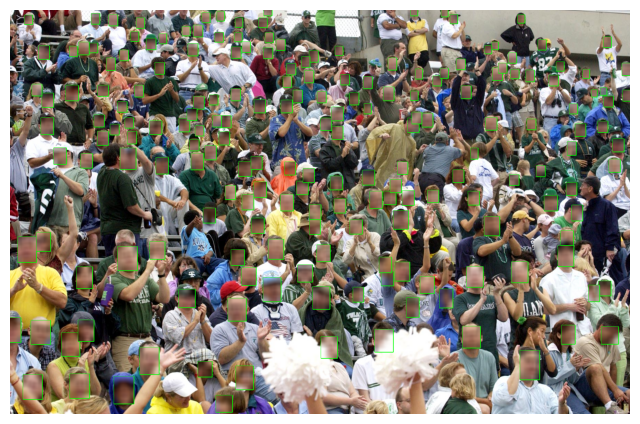

In [ ]:
for b in dets:
    # draw face bounding box around each detected face
    top_left = b.top_left.int().tolist()
    bottom_right = b.bottom_right.int().tolist()
    scores = b.score.tolist()

    for score, tp, br in zip(scores, top_left, bottom_right):
        x1, y1 = tp
        x2, y2 = br

        if score < 0.7:
            continue  # skip detection with low score
        img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # blur the detected faces
        apply_blur_face(img, img_vis, x1, y1, x2, y2)

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis("off")
plt.show()

## Play with the Real Time Demo

You can achieve 60 FPS in CPU using a standard WebCam.

See: [https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py](https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py)

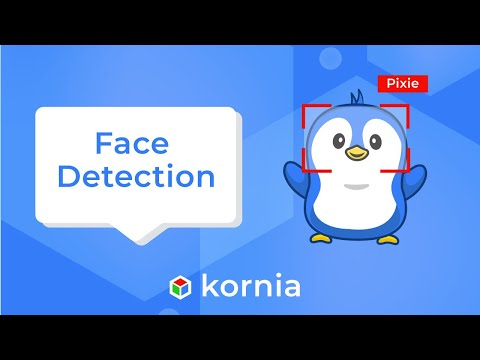

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("hzQroGp5FSQ")